In [1]:
# !pip --version

In [2]:
# !pip install tensorflow[and-cuda]

In [3]:
#3.11.4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics

2023-10-22 14:22:45.985289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 14:22:45.985345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 14:22:45.985372: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 14:22:46.005404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# get gpu
# tf.config.list_physical_devices('GPU')

In [5]:
data = pd.read_csv('./cancerDataset/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [6]:
labels = data['label']
data = data.drop(['label'], axis=1)

# Divide into Training (80%) and Test (20%) Sets

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_train shape:  (8012, 2352)
y_train shape:  (8012,)


# Plotting Class Distribution

In [8]:
# Function to plot the distribution of labels given the labels and their counts
def plotCountsBar(uniqueLabels,counts):
    plt.bar(uniqueLabels, counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of labels')
    plt.show()

In [9]:
# This fuction returns the unique labels and their counts for a given set of labels
# It gets the unique labels and sorts them to make sure order is persistent
# It then iterates over the unique labels and counts the number of labels that match that unique label
# It returns the unique labels and their counts
def countsPerLabel(labels):
    uniqueLabels = np.unique(labels)
    uniqueLabels = np.sort(uniqueLabels) # assure order of labels is ascending
    counts = []
    for uniqueLabel in uniqueLabels:
        print("Label: ", uniqueLabel,end=' ')
        count = len(labels[labels == uniqueLabel])
        print("Count: ", count)
        counts.append(count)
    return uniqueLabels,counts

Label:  0 Count:  258
Label:  1 Count:  421
Label:  2 Count:  871
Label:  3 Count:  87
Label:  4 Count:  5367
Label:  5 Count:  121
Label:  6 Count:  887


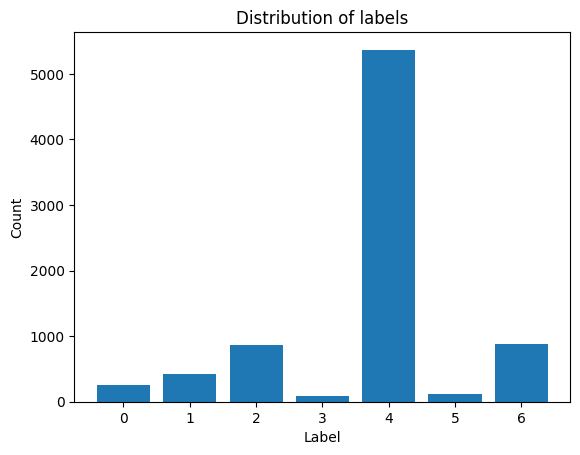

In [10]:
uniqueLabels,counts = countsPerLabel(y_train)
plotCountsBar(uniqueLabels,counts)

# Perform Oversampling on Training Set

In [11]:
import random
from imblearn.over_sampling import RandomOverSampler 
# here classes are balanced by randomly oversampling the minority classes to match the majority class
overSampler = RandomOverSampler(random_state=42)
x_train, y_train = overSampler.fit_resample(x_train, y_train)

Label:  0 Count:  5367
Label:  1 Count:  5367
Label:  2 Count:  5367
Label:  3 Count:  5367
Label:  4 Count:  5367
Label:  5 Count:  5367
Label:  6 Count:  5367


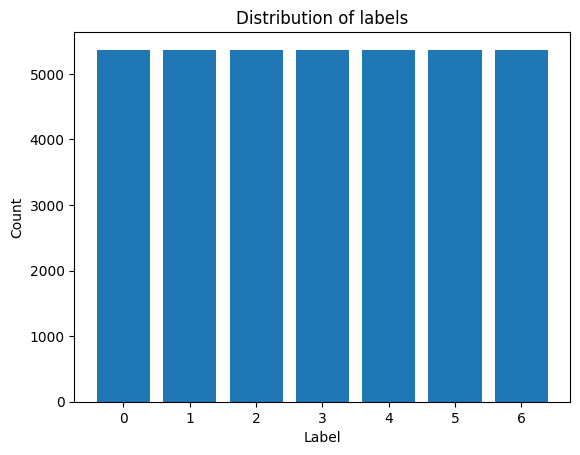

In [12]:
uniqueLabels,counts = countsPerLabel(y_train)
plotCountsBar(uniqueLabels,counts)

In [13]:
# the data needs to be reshaped to be 28x28x3
x_train=np.array(x_train).reshape(-1,28,28,3)

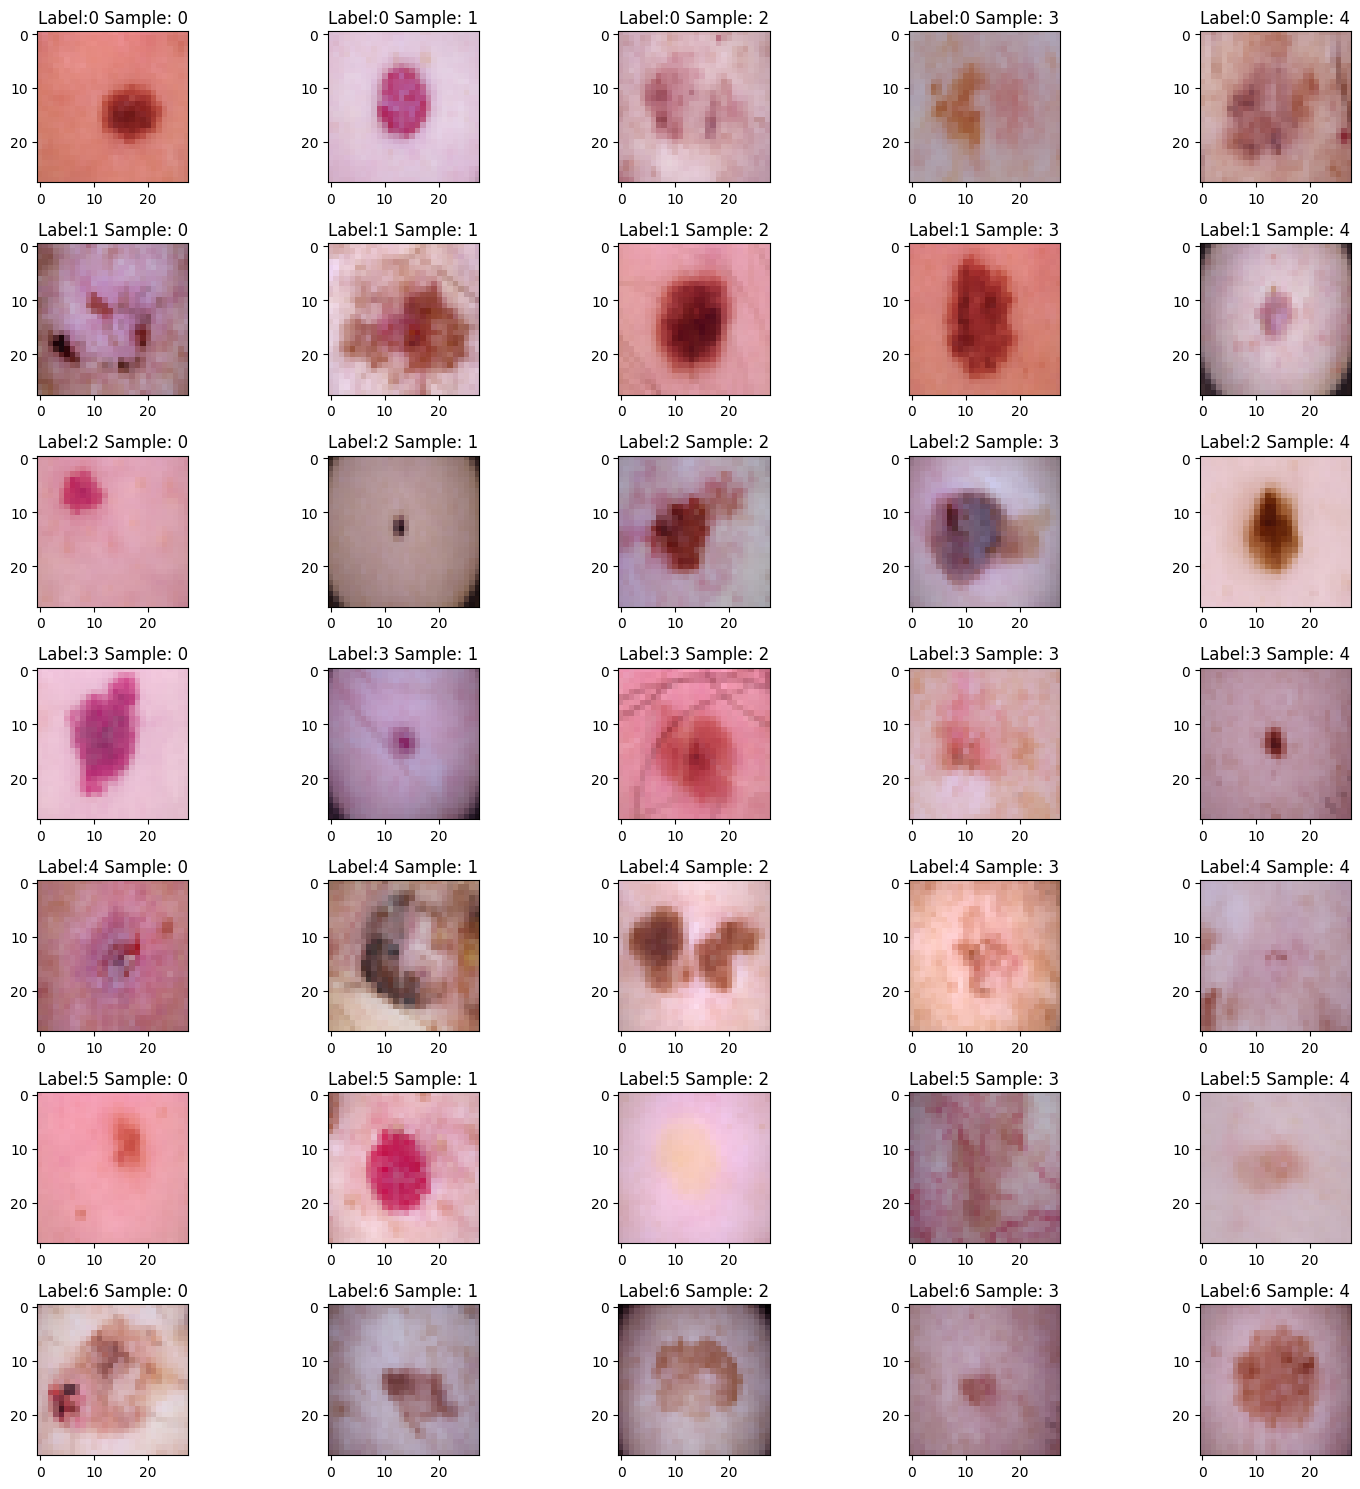

In [14]:
#show training 5 samples for each class
fig, ax = plt.subplots(7,5)
fig.set_size_inches(15,15)
for i in range(7):
    for j in range (5):
        randomIndex = random.randint(0, len(x_train))
        ax[i,j].imshow(x_train[randomIndex])
        ax[i,j].set_title("Label:" + str(i) + " Sample: " + str(j))
        # ax[i,j].set_title(y_train[randomIndex])
plt.tight_layout()


In [15]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout

# this function defines the model given the learning rate and dropout rate
# it returns the model and is used in the hyperparameter tuning

def defineModel(lr,dropout):
    # CNN
    model = keras.Sequential()
    model.add(Conv2D(32, kernel_size = (2,2), input_shape = (28, 28, 3), activation = 'relu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization()) # normalize
    model.add(MaxPool2D(pool_size = (2,2)))

    # model.add(Conv2D(64, kernel_size = (5,5), activation = 'relu')) # bigger kernel
    model.add(Conv2D(32, kernel_size = (1,1), activation = 'relu')) # reduce depth
    model.add(BatchNormalization()) # normalize
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Flatten())
    # NN
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(dropout))
    # model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(7,activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
    return model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gc

# this callback stops training when the validation accuracy reaches 1.0
# this is used to speed up hyperparameter tuning and ensure the model is not overfitting
class StopTrainingOn1Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs and logs.get('val_accuracy') == 1.0:
            self.model.stop_training = True

# this callback stops training when the validation given that there is no improvement in the validation accuracy for 5 epochs
earlyStop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# this callback reduces the learning rate by half if there is no improvement in the validation accuracy for 3 epochs
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=0.00001)

callbacks = [earlyStop, reduceLR, StopTrainingOn1Callback()]

pram_grid = {
    'lr': [0.001],
    'dropout': [0.2, 0.3],
    'batch_size': [64,128,256],
    'epochs': [50]
    
}

# this function tunes the hyperparameters given a parameter grid
# it returns the best model, best parameters, and the history of the best model
# best model is the model with the highest validation accuracy
def tuneHyperparameters(param_grid):
    bestModel = None
    bestAccuracy = float('-inf')
    bestParams = None
    bestHistory = None
    
    for lr in param_grid['lr']:
        for dr in param_grid['dropout']:
            for bs in param_grid['batch_size']:
                for ep in param_grid['epochs']:
                    print("lr: ", lr, " dr: ", dr, " bs: ", bs, " ep: ", ep)
                    model = defineModel(lr,dr)
                    with tf.device('/GPU:0'):
                        history = model.fit(x_train, y_train, batch_size=bs, epochs=ep, validation_split=0.2, callbacks=callbacks,shuffle=True)
                    accuracy = history.history['val_accuracy'][-1]
                    if accuracy > bestAccuracy:
                        bestAccuracy = accuracy
                        bestModel = model
                        bestParams = {'lr': lr, 'dropout': dr, 'batch_size': bs, 'epochs': ep}
                        bestHistory = history
                    gc.collect()
    print("Best val_accuracy: ", bestAccuracy)
    print("Best params: ", bestParams)
    return bestModel, bestParams, bestHistory


In [16]:
bestModel, bestParams, status = tuneHyperparameters(pram_grid)

lr:  0.001  dr:  0.2  bs:  64  ep:  50
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 25, 25, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        2080      
                                                                 
 batch_normalizat

2023-10-22 14:22:57.498328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 14:22:57.508013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 14:22:57.508078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 14:22:57.511511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 14:22:57.511573: I tensorflow/compile

Epoch 1/50


2023-10-22 14:22:59.339737: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 565514880 exceeds 10% of free system memory.
2023-10-22 14:22:59.723390: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 565514880 exceeds 10% of free system memory.
2023-10-22 14:23:02.064623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-22 14:23:04.272545: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7744523510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 14:23:04.272593: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-10-22 14:23:04.290037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-22 14:23:04.396659: I ./tensorflow/compiler/jit

470/470 [==============================] - 13s 13ms/step - loss: 0.9276 - accuracy: 0.6787 - val_loss: 2.2681 - val_accuracy: 0.2059 - lr: 0.0010
Epoch 2/50
470/470 [==============================] - 5s 11ms/step - loss: 0.4408 - accuracy: 0.8495 - val_loss: 2.0405 - val_accuracy: 0.2965 - lr: 0.0010
Epoch 3/50
470/470 [==============================] - 5s 10ms/step - loss: 0.3101 - accuracy: 0.8928 - val_loss: 1.1692 - val_accuracy: 0.4227 - lr: 0.0010
Epoch 4/50
470/470 [==============================] - 5s 11ms/step - loss: 0.2691 - accuracy: 0.9056 - val_loss: 1.3404 - val_accuracy: 0.4357 - lr: 0.0010
Epoch 5/50
470/470 [==============================] - 5s 11ms/step - loss: 0.2233 - accuracy: 0.9209 - val_loss: 0.9893 - val_accuracy: 0.5053 - lr: 0.0010
Epoch 6/50
470/470 [==============================] - 5s 11ms/step - loss: 0.2008 - accuracy: 0.9290 - val_loss: 0.6336 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 7/50
470/470 [==============================] - 5s 11ms/step - loss:

2023-10-22 14:24:05.817544: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 565514880 exceeds 10% of free system memory.
2023-10-22 14:24:06.491998: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 565514880 exceeds 10% of free system memory.


Epoch 1/50
235/235 [==============================] - 7s 18ms/step - loss: 0.9395 - accuracy: 0.6731 - val_loss: 1.9644 - val_accuracy: 0.3701 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 3s 14ms/step - loss: 0.3965 - accuracy: 0.8700 - val_loss: 1.4663 - val_accuracy: 0.3973 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - 3s 14ms/step - loss: 0.2601 - accuracy: 0.9128 - val_loss: 1.1970 - val_accuracy: 0.5594 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1970 - accuracy: 0.9327 - val_loss: 0.9424 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 5/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1757 - accuracy: 0.9396 - val_loss: 0.3199 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 6/50
235/235 [==============================] - 3s 13ms/step - loss: 0.1444 - accuracy: 0.9507 - val_loss: 0.3346 - val_accuracy: 0.8637 - lr: 0.0010
Epoch 7/50
235/235 [==============================] - 3s 14ms/st

2023-10-22 14:26:12.447127: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 565514880 exceeds 10% of free system memory.


Epoch 1/50
118/118 [==============================] - 6s 24ms/step - loss: 1.0138 - accuracy: 0.6452 - val_loss: 4.4557 - val_accuracy: 0.0584 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 2s 20ms/step - loss: 0.4397 - accuracy: 0.8561 - val_loss: 1.7941 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 2s 20ms/step - loss: 0.2790 - accuracy: 0.9074 - val_loss: 0.6450 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 2s 20ms/step - loss: 0.2192 - accuracy: 0.9266 - val_loss: 1.6112 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 2s 20ms/step - loss: 0.1749 - accuracy: 0.9396 - val_loss: 0.6083 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 6/50
118/118 [==============================] - 2s 20ms/step - loss: 0.1434 - accuracy: 0.9499 - val_loss: 0.8207 - val_accuracy: 0.6057 - lr: 0.0010
Epoch 7/50
118/118 [==============================] - 2s 20ms/st

In [17]:
# model.save('task1.keras')

In [18]:
x_test=np.array(x_test).reshape(-1,28,28,3)

In [19]:
x_test.shape

(2003, 28, 28, 3)

# Training Accuray and Loss

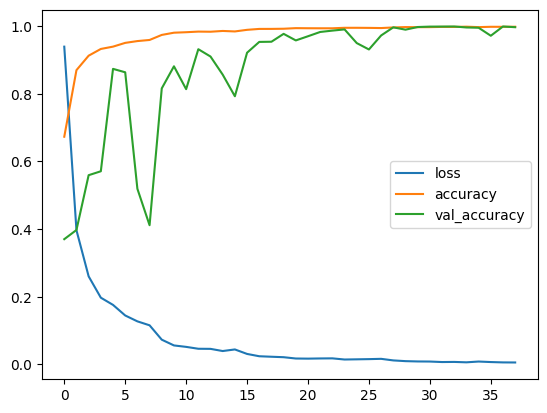

In [20]:
plt.plot(status.history['loss'])
plt.plot(status.history['accuracy'])
plt.plot(status.history['val_accuracy'])
plt.legend(['loss','accuracy','val_accuracy'])


# Evaluate on Test Data

In [21]:
with tf.device('/GPU:0'):
    status = bestModel.evaluate(x_test, y_test,use_multiprocessing=True)
print("Loss: ", status[0])
print("Accuracy: ", status[1]*100)

63/63 [==============================] - 0s 6ms/step - loss: 1.6468 - accuracy: 0.7554
Loss:  1.646753191947937
Accuracy:  75.53669214248657


In [22]:
# this is used to predict the classes given the model and the data
# it returns the class propapilities
def predict_classes(model, x_test):
    y_pred = bestModel.predict(x_test)
    classes = np.argmax(y_pred, axis = 1)
    return classes

In [23]:
# plot test error
print("Test Loss:", status[0]) 
print("Test Accuracy:", status[1]*100)


Test Loss: 1.646753191947937
Test Accuracy: 75.53669214248657


63/63 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.46      0.25      0.32        69
           1       0.48      0.57      0.52        93
           2       0.52      0.43      0.47       228
           3       0.60      0.21      0.32        28
           4       0.87      0.91      0.89      1338
           5       0.75      0.57      0.65        21
           6       0.45      0.50      0.47       226

    accuracy                           0.76      2003
   macro avg       0.59      0.49      0.52      2003
weighted avg       0.75      0.76      0.75      2003



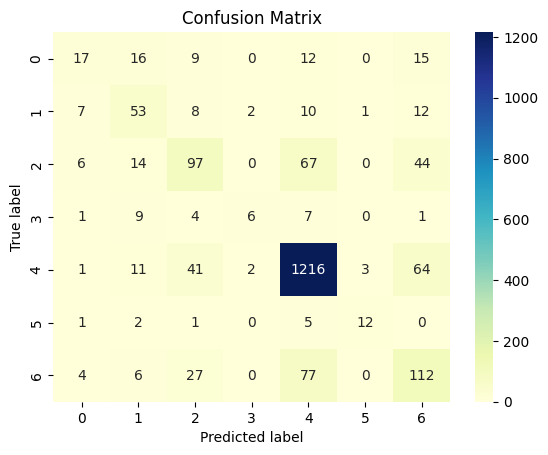

In [24]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = predict_classes(bestModel, x_test)
confusionMatrixData = confusion_matrix(y_test, y_pred)
# heat map of confusion matrix with x and y axis labels
fig = sns.heatmap(confusionMatrixData, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(7), yticklabels=range(7))
fig.set(xlabel='Predicted label', ylabel='True label', title='Confusion Matrix')
print(metrics.classification_report(y_test, y_pred))

In [25]:
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score, accuracy_score, classification_report
MSE = mean_squared_error(y_test, y_pred)
print("MSE: ", MSE)

F1 = f1_score(y_test, y_pred, average='macro')
print("F1: ", F1)

precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

recall = recall_score(y_test, y_pred, average='macro')
print("Recall: ", recall)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy*100)

cr = classification_report(y_test, y_pred)
print("Classification Report: \n", cr)

MSE:  1.963554667998003
F1:  0.5192906769116286
Precision:  0.589939473896062
Recall:  0.4902595030273305
Accuracy:  75.53669495756365
Classification Report: 
               precision    recall  f1-score   support

           0       0.46      0.25      0.32        69
           1       0.48      0.57      0.52        93
           2       0.52      0.43      0.47       228
           3       0.60      0.21      0.32        28
           4       0.87      0.91      0.89      1338
           5       0.75      0.57      0.65        21
           6       0.45      0.50      0.47       226

    accuracy                           0.76      2003
   macro avg       0.59      0.49      0.52      2003
weighted avg       0.75      0.76      0.75      2003



In [27]:
bestModel.save('task1.keras')